# Cеминар 5. Языковое моделирование (N-граммы и RNN)

На этом семинаре мы поговорим с вами про языковое моделирование, а посмотрим и на классику (N-граммы) и современный подход (RNN):
  
  * **Часть 1:** N-граммные модели (теория, подсчет, генерация).
  * **Часть 2:** Метрики (Перплексия) и проблема разреженности (Сглаживание - обзорно).
  * **Часть 3:** Нейросетевые модели (Char-level RNN).

**Об источнике материалов**

Настоящая семинарская тетрадь основана на материалах открытого курса YSDA Natural Language Processing (Yandex School of Data Analysis, автор курса - Elena Voita), размещённого в репозитории <https://github.com/yandexdataschool/nlp_course> (лицензия MIT). При подготовке были частично использованы и адаптированы следующие ноутбуки:

- `week02_lm/homework_pytorch.ipynb`  
- `week03_lm/seminar.ipynb`  

Все авторские права на исходные материалы принадлежат их авторам и Яндекс Школе анализа данных.  
Изменения и комментарии в данной тетрадке сделаны исключительно в учебных целях.


## Часть 1. N-граммные модели

Сегодня мы будем использвоать корпус статей с [ArXiv](http://arxiv.org/) и посмотрим, сможем ли мы сгенерировать новую научную статью - точнее хотя бы что-то более или менее вразумительное.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

In [2]:
data = pd.read_json("./arxivData.json")
data.sample(n=5)

,author,day,id,link,month,summary,tag,title,year
14199,"[{'name': 'Albert Lee'}, {'name': 'Bonnie Lam'...",13,1803.05006v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"In this paper, we propose a new scheme for mod...","[{'term': 'cs.NE', 'scheme': 'http://arxiv.org...",Conditional Activation for Diverse Neurons in ...,2018
27105,"[{'name': 'Huimin Lu'}, {'name': 'Yujie Li'}, ...",13,1702.03600v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,Underwater cameras are widely used to observe ...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Underwater Optical Image Processing: A Compreh...,2017
30077,"[{'name': 'Fuqing Zhu'}, {'name': 'Xiangwei Ko...",17,1711.06500v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,An intrinsic challenge of person re-identifica...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Pseudo-positive regularization for deep person...,2017
32687,"[{'name': 'Changsheng Li'}, {'name': 'Qingshan...",16,1412.4863v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",12,"In this paper, we propose a new max-margin bas...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Max-Margin based Discriminative Feature Learning,2014
14400,"[{'name': 'Yoshihiko Gotoh'}, {'name': 'Steve ...",29,cs/0003081v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,The rate of occurrence of words is not uniform...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Variable Word Rate N-grams,2000



Соберем строки: склеим заголовок и описание статьи.

In [3]:
# склеиваем заголовок и аннотацию
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'].replace("\n", ' '), axis=1).tolist()

sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Токенизация

Данные грязные. Вы знаете, что делать. Используйте `WordPunctTokenizer` или что-то подобное, чтобы разбить текст на токены.

In [4]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

# наша задача: преобразовать lines (in-place) в список строк, где токены разделены пробелом.
# приведем все к нижнему регистру.

lines = [' '.join(tokenizer.tokenize(line.lower())) for line in lines]

assert sorted(lines, key=len)[0] == \
    'differential contrastive divergence ; this paper has been retracted .'
assert sorted(lines, key=len)[2] == \
    'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .'

### N-граммная языковая модель

Языковая модель (LM) - это вероятностная модель, которая оценивает вероятность текста: совместную вероятность всех токенов $w_t$ в тексте $X$: $P(X) = P(w_1, \dots, w_T)$.

По цепному правилу (chain rule):
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$

Проблема этого подхода в том, что последний член $P(w_T \mid w_1, \dots, w_{T-1})$ зависит от $n-1$ предыдущих слов. Оценить эту вероятность для длинных текстов (например, $T=1000$) невозможно из-за нехватки данных.

Популярное упрощение - предположить, что следующее слово зависит только от фиксированного количества предыдущих слов:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Такая модель называется **n-граммной языковой моделью**, где n - параметр. Например, в 3-граммной модели (триграммной) каждое слово зависит только от 2 предыдущих.

Первый шаг - подсчитать количество вхождений слов после N-1 предыдущих слов.



In [5]:
from tqdm import tqdm
from collections import defaultdict, Counter

# спецтокены:
# - `UNK` обозначает неизвестные токены (которых не было в обучающей выборке)
# - `EOS` специальный токен конца последовательности

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Считаем, сколько раз каждое слово встречалось после (n - 1) предыдущих слов.
    :param lines: итерируемый объект строк (где токены разделены пробелом)
    :returns: словарь { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}

    При подсчете учтите два граничных случая:
    - если префикс короче (n-1) токенов, его нужно дополнить UNK. Для n=3:
      пустой префикс: "" -> (UNK, UNK)
      короткий префикс: "the" -> (UNK, the)
      длинный префикс: "the new approach" -> (new, approach)
    - вы должны добавить специальный токен EOS в конец каждой последовательности
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      считайте вероятность этого токена так же, как и других.
    """
    counts = defaultdict(Counter)
    # counts[(word1, word2)][word3] = сколько раз word3 встретился после (word1, word2)

    for line in lines:
        tokens = line.split()
        # добавляем EOS
        tokens = tokens + [EOS]

        # добавляем паддинг в начало (n-1 штук UNK)
        padding = [UNK] * (n - 1)
        tokens = padding + tokens

        # итерируемся и считаем
        for i in range(n - 1, len(tokens)):
            # берем срез длины n-1 перед текущим токеном
            prefix = tuple(tokens[i - n + 1 : i])
            target = tokens[i]
            counts[prefix][target] += 1

    return counts

In [6]:
# Тесты
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "пожалуйста, считайте только {n-1}-граммы"
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3
assert dummy_counts['p', '=']['np'] == 2
assert dummy_counts['author', '.']['_EOS_'] == 1
print("Тесты пройдены!")

Тесты пройдены!


Когда мы умеем считать N-граммы, можно строить вероятностную модель.
Простейший способ - считать вероятности пропорционально частотам:

$$P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) }$$

In [7]:
class NGramLanguageModel:
    def __init__(self, lines, n):
        """
        Обучение простой count-based модели:
        считаем вероятности P(w_t | prefix) на основе частот n-грамм
        """
        assert n >= 1
        self.n = n

        counts = count_ngrams(lines, self.n)

        # вычисляем вероятности
        self.probs = defaultdict(Counter)
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)

        for prefix, token_counts in counts.items():
            total_count = sum(token_counts.values())
            for token, count in token_counts.items():
                self.probs[prefix][token] = count / total_count

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: строка с префиксом (токены через пробел)
        :returns: словарь {token : probability} для всех токенов с ненулевой вероятностью
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]

    def get_next_token_prob(self, prefix, next_token):
        """
        :returns: P(next_token|prefix) число, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Давайте протестируем:

In [8]:
dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(sum(p_initial.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "ваша 3-граммная модель должна зависеть только от 2 предыдущих слов"
print("Все работает!")

Все работает!


### Генерация текста

Обучим модель на всем датасете.

In [9]:
lm = NGramLanguageModel(lines, n=3)

Процесс генерации итеративен. Мы поддерживаем список токенов и добавляем следующий, сэмплируя его из распределения вероятностей.

$$w_{next} \sim P(w_{next} | X)$$

Можно также использовать **температуру**. В этом случае сэмплирование идет из:

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Где $\tau > 0$ — температура. Если $\tau << 1$, более вероятные токены становятся еще вероятнее (модель более "уверенная" и консервативная).

In [10]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    возвращает следующий токен после префикса;
    :param temperature: сэмплирование пропорционально вероятностям ^ (1 / temperature)
        если temperature == 0, всегда берем самый вероятный токен.
    """
    token_probs = lm.get_possible_next_tokens(prefix)
    if not token_probs:
        return EOS

    tokens = list(token_probs.keys())
    probs = np.array(list(token_probs.values()))

    if temperature == 0:
        return tokens[np.argmax(probs)]

    # применяем температуру
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)

    return np.random.choice(tokens, p=probs)

Попробуем сгенерировать что-нибудь:

In [11]:
prefix = 'artificial' # :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break

print(prefix)

artificial brain signals captured using a probability map for the supervised and unsupervised settings . the deep neural networks , including a method for modeling the sequence to sequence ( seq2seq ) framework , a varying number of design adaptation and recommendation data available for those tasks . all local minima , then the standard convergence properties of the volume spanned by all possible explanations , and dynamically assigns multiple mapping volumes . to work fairly well , if not , unlike many compression algorithms ; in order to show the variability of structure . in addition to increasing availability of


artificial neural networks and more robust to skewed , high , running with gpu implementations of them include redundant or approximately best ) basic element sets in order to overcome this bottleneck and intractable settings . in fact the retrieved sss , which is more challenging for machine learning models , however , training nonlinear kernel support vector regression ; in standard benchmark datasets of uefa injury recordings were available only for convolutional and recurrent neural network ( 3d - acceleration for machine learning for games with enormous variations in instructions , given various desired levels of organisation within language families

## Часть 2: Перплексия (Оценка качества)

Перплексия (Perplexity) - мера того, насколько хорошо модель предсказывает выборку. **Меньше перплексия = лучше модель**.

$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


На уровне корпуса перплексия - это произведение вероятностей всех токенов во всех предложениях в степени $1/N$, где $N$ - **общая длина всех токенов**.

Число может получиться очень маленьким, поэтому рекомендуем работать с логарифмами (log-perplexity), а затем брать экспоненту.

In [12]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: список строк (токенов через пробел)
    :param min_logprob: если log(P(w | ...)) меньше этого порога, заменяем его на порог (чтобы не было -inf)
    :returns: перплексия корпуса (скаляр)
    """
    total_log_prob = 0
    N = 0

    for line in lines:
        tokens = line.split() + [EOS]
        for i, token in enumerate(tokens):
            N += 1

            # формируем префикс для текущего токена
            prefix = ' '.join(tokens[:i])
            prob = lm.get_next_token_prob(prefix, token)
            log_prob = np.log(prob) if prob > 0 else min_logprob
            log_prob = max(log_prob, min_logprob)

            total_log_prob += log_prob

    return np.exp(-total_log_prob / N)

lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


Посмотрим на валидации:

In [13]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


**Ой, все взорвалось\!** Перплексия огромная.
Проблема в том, что наша модель присваивает вероятность 0 любым N-граммам, которые она не видела в обучении (а в тесте они есть).

Для борьбы с этим используется **сглаживание (Smoothing)** (например, Лапласа или Кнезера-Нея), которое перераспределяет вероятность так, чтобы ничего не имело строго нулевой вероятности.

### Сглаживание языковых моделей (LM Smoothing)

Проблема нашей простой модели в том, что если она встречает n-грамму, которую никогда не видела раньше, она присваивает ей вероятность **0**. Каждый раз, когда это происходит, перплексия улетает в бесконечность.

Чтобы бороться с этим, используют технику **сглаживания (smoothing)**. Основная идея - модифицировать счетчики так, чтобы вероятности никогда не были строго нулевыми.

Самый простой алгоритм - **Аддитивное сглаживание** (или [сглаживание Лапласа](https://www.google.com/search?q=https://ru.wikipedia.org/wiki/%25D0%2590%25D0%25B4%25D0%25B4%25D0%25B8%25D1%2582%25D0%25B8%25D0%25B2%25D0%25BD%25D0%25BE%25D0%25B5_%25D1%2581%25D0%25B3%25D0%25BB%25D0%25B0%25D0%25B6%25D0%25B8%25D0%25B2%25D0%25B0%25D0%25BD%25D0%25B8%25D0%25B5)):

$$P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) }$$

Если счетчики для данного префикса малы, аддитивное сглаживание приближает распределение к равномерному. Обратите внимание, что суммирование в знаменателе идет по **всем словам в словаре**.

Вот пример реализации (менять его не нужно, используйте как образец):

In [14]:
class LaplaceLanguageModel(NGramLanguageModel):
    """ пример кода, менять не нужно """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n)
        self.vocab = set(token for token_counts in counts.values() for token in token_counts)
        self.probs = defaultdict(Counter)

        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab)
            self.probs[prefix] = {token: (token_counts[token] + delta) / total_count
                                  for token in token_counts}

    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}

    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # предотвращаем ошибки округления
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))

# Важно: эта реализация предполагает, что все неизвестные слова в данном контексте равновероятны.
# Сравнивать перплексию этой модели с моделью, где меньше неизвестных слов, не совсем честно,
# но для учебного примера подходит.

Проверим, что это работает:


In [15]:
# тест на валидность распределения
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "Сумма вероятностей должна быть 1!"

# проверяем перплексию на тесте (теперь она не должна быть бесконечной)
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=0.1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 1832.66878
N = 2, Perplexity = 470.48021
N = 3, Perplexity = 3679.44765


### Сглаживание Кнезера-Нея

Аддитивное сглаживание - это просто, но далеко не State of The Art.

Ваша финальная задача в этой секции - реализовать [сглаживание Кнезера-Нея](https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing).

Оно вычисляется рекурсивно для $n>1$:

$$P_{kn}(w_t | prefix_{n-1}) = { \max(0, Count(prefix_{n-1}, w_t) - \delta) \over \sum_{\hat w} Count(prefix_{n-1}, \hat w)} + \lambda_{prefix_{n-1}} \cdot P_{kn}(w_t | prefix_{n-2})$$

где:

  - $prefix_{n-1}$ - кортеж из $n-1$ предыдущих токенов.
  - $\lambda_{prefix_{n-1}}$ - константа нормализации, выбранная так, чтобы вероятности суммировались в 1.
  - $P_{kn}(w_t | prefix_{n-2})$ - сглаживание Кнезера-Нея для $(n-1)$-граммной модели (рекурсия).
  - Униграмма $P_{kn}(w_t)$ - это особый случай: какова вероятность встретить $w_t$ в незнакомом контексте (обычно оценивается через частоту, с которой слово завершает *любые* другие биграммы).

> Про код, который пойдет дальше:
>
>1.  **Рекурсия (`self.backoff_model`)**. Самая важная часть. Мы создаем цепочку моделей: `3-gram -> 2-gram -> 1-gram`. Когда 3-граммная модель считает вероятность, она использует свою статистику + спрашивает уточнение у 2-граммной (через коэффициент $\lambda$).
> 2.  **Словарь (`self.vocab`)**. В методе `get_possible_next_tokens` мы вынуждены итерироваться по всему словарю. В отличие от обычной N-граммной модели, где вероятность 0, если слова не было в контексте, в Kneser-Ney вероятность размазывается по всем словам, которые встречались в обучающей выборке (через униграммный хвост).
> 3.  **Формула**:
      * `max(0, count - delta) / sum_counts` - мы отщипываем кусочек вероятности у частых слов.
      * `lam * prob_backoff` - и отдаем этот кусочек (пропорционально $\lambda$) младшей модели, которая распределяет его между более редкими словами или словами, не встречавшимися в этом конкретном контексте, но частыми глобально.

In [16]:
class KneserNeyLanguageModel(NGramLanguageModel):
    """
    Реализация Interpolated Absolute Discounting (упрощенная версия Kneser-Ney).
    Использует рекурсию для обращения к модели (n-1).
    """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        self.delta = delta

        # считаем N-граммы для текущего порядка n
        self.counts = count_ngrams(lines, self.n)

        # собираем словарь (нужен для unigram-модели и валидации)
        # проходим по всем контекстам и собираем все встреченные токены
        self.vocab = set()
        for context in self.counts:
            for token in self.counts[context]:
                self.vocab.add(token)

        # инициализируем модель младшего порядка (backoff)
        if n > 1:
            self.backoff_model = KneserNeyLanguageModel(lines, n - 1, delta)
        else:
            self.backoff_model = None
            # для униграмм считаем общее количество токенов для знаменателя
            self.total_count = sum(sum(c.values()) for c in self.counts.values())

    def get_next_token_prob(self, prefix, next_token):
        # базовый случай: Униграммная модель (n=1)
        if self.n == 1:
            # для униграммы контекст пустой tuple()
            # берем вероятность как count / total
            count = self.counts.get(tuple(), {}).get(next_token, 0)
            return count / max(1, self.total_count)

        # подготовка префикса для N-граммной модели (n > 1)
        prefix_tokens = prefix.split()
        # сставляем только n-1 последних слов
        prefix_tokens = prefix_tokens[max(0, len(prefix_tokens) - self.n + 1):]
        # паддинг UNK-ами, если префикс слишком короткий (как в count_ngrams)
        prefix_tokens = [UNK] * (self.n - 1 - len(prefix_tokens)) + prefix_tokens
        prefix_tuple = tuple(prefix_tokens)

        # получаем счетчики
        token_counts = self.counts[prefix_tuple]
        total_context_count = sum(token_counts.values())

        # вычисляем вероятность
        if total_context_count > 0:
            # слагаемое 1: Discounted probability (вычитаем дельту)
            count = token_counts.get(next_token, 0)
            prob_discounted = max(0, count - self.delta) / total_context_count

            # слагаемое 2: Interpolation (лямбда * вероятность младшей модели)
            # лямбда зависит от количества уникальных слов, продолжающих этот контекст
            num_unique_continuations = len(token_counts)
            lam = (self.delta * num_unique_continuations) / total_context_count

            # рекурсивный вызов к модели (n-1).
            # передаем префикс без первого слова, чтобы он подошел для n-1.
            backoff_prefix = ' '.join(prefix_tokens[1:])
            prob_backoff = self.backoff_model.get_next_token_prob(backoff_prefix, next_token)

            return prob_discounted + lam * prob_backoff
        else:
            # если такой контекст не встречался, полностью доверяем младшей модели
            backoff_prefix = ' '.join(prefix_tokens[1:])
            return self.backoff_model.get_next_token_prob(backoff_prefix, next_token)

    def get_possible_next_tokens(self, prefix):
        # в KN вероятность может быть ненулевой для любого слова из словаря (из-за backoff),
        # поэтому мы должны вернуть вероятности для всего словаря.
        # это неэффективно для продакшена, но нужно для тестов assert sum() == 1
        return {
            token: self.get_next_token_prob(prefix, token)
            for token in self.vocab
        }

for n in (1, 2, 3):
    dummy_lm = KneserNeyLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "Сумма вероятностей должна быть 1"

for n in (1, 2, 3):
    lm = KneserNeyLanguageModel(train_lines, n=n, delta=0.5) # Попробуйте разные delta
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 410.34415
N = 3, Perplexity = 342.64407


## Часть 3: Нейросетевые модели (RNN)

Статистические модели работают неплохо, но они плохо обобщаются и требуют сложного сглаживания. Давайте перейдем к Deep Learning.

Мы будем строить **посимвольную (character-level)** модель. Это значит, что словарь у нас будет маленьким (только символы), но последовательности станут длинными.

### Подготовка данных

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# спецтокены
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# собираем словарь символов
tokens = sorted(list(set(''.join(lines))))
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

# map символов в индексы
token_to_id = {token: i for i, token in enumerate(tokens)}

n_tokens =  136


Функция для перевода строк в матрицу индексов (с паддингом):

In [18]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Преобразует список строк в матрицу индексов (batch, length)"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

### RNN Language Model

Мы будем использовать рекуррентную сеть. Она обрабатывает один токен за раз, поддерживая скрытое состояние (hidden state).

$$h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t)$$
$$p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1})$$

In [19]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Рекуррентная модель:
        1. Эмбеддинги
        2. RNN/LSTM/GRU слой
        3. Линейный слой для логитов
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, emb_size)
        # batch_first=True важен, так как наши данные имеют размерность [batch, time]
        self.rnn = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hid_size, n_tokens)

    def __call__(self, input_ix):
        """
        input_ix: [batch_size, sequence_length]
        returns: [batch_size, sequence_length, n_tokens]
        """
        embeds = self.emb(input_ix)
        rnn_out, _ = self.rnn(embeds)
        logits = self.hid_to_logits(rnn_out)
        return logits

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ Генерация: возвращает вероятности следующего токена """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            logits = self(prefix_ix)[0, -1] # берем логиты последнего шага
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        return dict(zip(tokens, probs))

### Обучение

Функция потерь - стандартная кросс-энтропия. Важно не считать лосс по паддингу.


In [20]:
def compute_loss(model, input_ix):
    """
    model: нейросеть
    input_ix: матрица токенов int32 [batch_size, length] (уже с EOS)
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)

    # предсказываем следующий токен:
    # вход: всё, кроме последнего токена
    logits = model(input_ix[:, :-1])
    # цель: всё, кроме первого токена (BOS)
    reference_answers = input_ix[:, 1:]

    # считаем CrossEntropy
    # reshape нужен, так как cross_entropy ожидает (N, C) и (N)
    loss = F.cross_entropy(
        logits.reshape(-1, n_tokens),
        reference_answers.reshape(-1),
        ignore_index=token_to_id[EOS] # или можно явно маскировать, но ignore_index удобнее
        # если мы используем EOS как паддинг, это работает.
        # но если паддинг - отдельный токен, нужно игнорировать его.
    )

    return loss

Вспомогательная функция генерации для проверки обучения:

In [21]:
def generate(model, prefix=' ', temperature=1.0, max_len=100):
    """
    Базовая функция генерации текста одной строкой.
    """
    model.eval() # режим оценки (выключает dropout, если он есть)
    device = next(model.parameters()).device

    # превращаем префикс в индексы и отправляем на устройство
    prefix_ix = torch.tensor(to_matrix([prefix]), dtype=torch.int64).to(device)

    with torch.no_grad():
        while True:
            # логиты
            logits = model(prefix_ix)[0, -1]
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

            # маппинг токен -> вероятность
            token_probs = dict(zip(tokens, probs))
            tokens_list = list(token_probs.keys())
            probs_list = np.array(list(token_probs.values()))

            if temperature == 0:
                # жадный выбор (argmax)
                next_token = tokens_list[np.argmax(probs_list)]
            else:
                # сэмплирование с температурой
                # p_i ^ (1/T)
                probs_list = probs_list ** (1.0 / temperature)
                # нормализация, чтобы сумма была равна 1
                probs_list /= np.sum(probs_list)

                next_token = np.random.choice(tokens_list, p=probs_list)

            prefix += next_token

            # добавляем новый токен к входу
            new_ix = torch.tensor([[token_to_id.get(next_token, token_to_id[EOS])]], dtype=torch.int64).to(device)
            prefix_ix = torch.cat([prefix_ix, new_ix], dim=1)

            if next_token == EOS or len(prefix) > max_len: break

    return prefix

Цикл обучения:

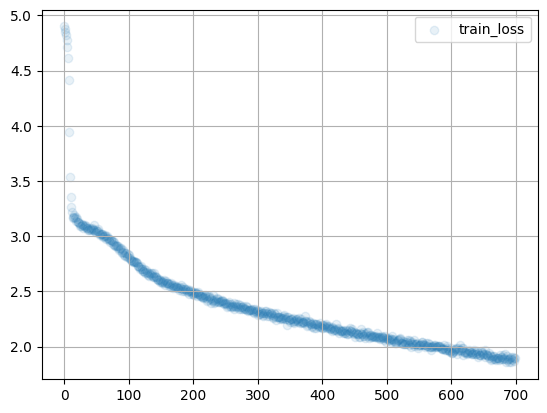

Пример генерации (tau=0.5):


 23%|██▎       | 700/3000 [21:50<1:16:01,  1.98s/it]

 Set complexing a date to problem a semant and Susting the mast a detwork for mate the iffection from


 24%|██▍       | 717/3000 [22:22<1:11:16,  1.87s/it]


KeyboardInterrupt: 

In [22]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from random import sample
from tqdm import trange

train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 64
model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())
train_history = []

for i in trange(3000): # 3000 шагов для семинара должно хватить для первых результатов
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Пример генерации (tau=0.5):")
        print(generate(model, temperature=0.5))

print("Final loss:", train_history[-1][-1])

In [24]:
def show_generations(model, prompts=['The', 'Neural', 'Deep', 'Author'], temperatures=[0.2, 0.5, 1.0]):
    """
    Функция для красивого вывода примеров генерации с разными параметрами.
    """
    for temp in temperatures:
        print(f"\n{'='*30}")
        print(f"Temperature: {temp}")
        print(f"{'='*30}")

        for prompt in prompts:

            generated_text = generate(model, prefix=prompt + " ", temperature=temp)

            # убираем лишние переносы строк для красоты вывода
            clean_text = generated_text.replace('\n', ' ')
            print(f"Prompt: '{prompt}' -> {clean_text}")

print("Генерация примеров обученной моделью:")
show_generations(model,
                 prompts=["The", "Machine", "Deep learning", "A novel"],
                 temperatures=[0.2, 0.5, 0.9])

Генерация примеров обученной моделью:

Temperature: 0.0
Prompt: 'The' -> The An the problem in the problem and the problem and the problem and the problem and the problem and
Prompt: 'Machine' -> Machine and the problem and the problem and the problem and the problem and the problem and the probl
Prompt: 'Deep learning' -> Deep learning and the problem and the problem and the problem and the problem and the problem and the
Prompt: 'A novel' -> A novel in the problem in the problem and the problem and the problem and the problem and the problem

Temperature: 0.1
Prompt: 'The' -> The An the problem in the problem in the problem and the problem in the problem the problem and the p
Prompt: 'Machine' -> Machine the problem the problem and the problem and the problem and the propose the problem and the p
Prompt: 'Deep learning' -> Deep learning and the propose and the problem and the problem and the problem the a senting the probl
Prompt: 'A novel' -> A novel to a manding the problem in the 

### Альтернативные стратегии сэмплирования

До сих пор мы сэмплировали токены из модели пропорционально их вероятностям.
Однако такой подход иногда порождает бессмысленные слова или грамматические ошибки, потому что softmax-вероятности редких токенов никогда не равны строгому нулю. Эту проблему можно частично решить с помощью температуры, но низкая температура убивает разнообразие (модель начинает повторяться).

Можно ли убрать бред, не жертвуя разнообразием? **Да\!** Но для этого нужны другие стратегии отбора.

**Top-k sampling:** на каждом шаге мы сэмплируем следующий токен только из **k наиболее вероятных** кандидатов.

Предположим, $k=3$, а вероятности токенов $p=[0.1, 0.35, 0.05, 0.2, 0.3]$.

1.  Выбираем $k$ лучших: 0.35, 0.3, 0.2.
2.  Обнуляем остальные: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$.
3.  Перенормируем, чтобы сумма была равна 1: $p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

**Nucleus sampling (Top-p):** похоже на top-k, но теперь мы выбираем $k$ динамически. В Nucleus sampling мы берем такой минимальный набор топ-токенов, чья суммарная вероятность (кумулятивная сумма) превышает порог **p** (или N в формулах).

Используем те же вероятности $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ и порог $p=0.9$.

1.  Самый вероятный токен $w_2$ ($0.35$), сумма $0.35 < 0.9$. Берем.
2.  Второй по вероятности $w_5$ ($0.3$), сумма $0.35 + 0.3 = 0.65 < 0.9$. Берем.
3.  Третий $w_4$ ($0.2$), сумма $0.65 + 0.2 = 0.85 < 0.9$. Берем.
4.  Четвертый $w_1$ ($0.1$), сумма $0.95 > 0.9$. Стоп. Этот уже не берем (или берем как последний, зависит от реализации, обычно отсекают "хвост", который дает \> p).

После выбора "ядра" (nucleus), мы перенормируем вероятности и сэмплируем.

In [27]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Генерация последовательности с помощью nucleus sampling
    :param prefix: строка с начальными токенами
    :param nucleus: порог p in [0, 1]
    :param max_len: максимальная длина генерации
    """
    device = next(model.parameters()).device

    prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)

    with torch.no_grad():
        while True:
            # логиты следующего токена
            logits = model(prefix_ix)[0, -1]
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

            # сортируем токены по убыванию вероятности
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]

            # посчитаем кумулятивную сумму
            cumulative_probs = np.cumsum(sorted_probs)

            # оставляем только те, где cumsum < nucleus
            # np.searchsorted находит первый индекс, где кумулятивная сумма >= nucleus
            cutoff_index = np.searchsorted(cumulative_probs, nucleus)

            # берем срез до cutoff_index + 1
            indices_to_keep = sorted_indices[:cutoff_index + 1]
            probs_to_keep = sorted_probs[:cutoff_index + 1]

            # перенормируем вероятности оставшихся
            probs_to_keep /= probs_to_keep.sum()

            # сэмплируем
            sampled_subset_idx = np.random.choice(len(probs_to_keep), p=probs_to_keep)

            # получаем реальный индекс токена
            next_token_ix = indices_to_keep[sampled_subset_idx]
            next_token = tokens[next_token_ix]

            prefix += next_token

            # обновляем prefix_ix для следующего шага
            new_token_ix = torch.tensor([[token_to_id.get(next_token, token_to_id[EOS])]], dtype=torch.int64).to(device)
            prefix_ix = torch.cat([prefix_ix, new_token_ix], dim=1)

            if next_token == EOS or len(prefix) > max_len: break

    return prefix

# перед запуском убедись, что ты запустил ячейку с обучением (Training Loop)!
# если модель не обучена, она будет выдавать бред вроде "s`haeo cetiteaeig".

print("Пример генерации (Nucleus):")
print(generate_nucleus(model, prefix="The ", nucleus=0.8))

Пример генерации (Nucleus):
The Reapled reves to a mandorations algorimeng a tres and efferch panding marding posston hegerition 





### Beam Search (Лучевой поиск)



Иногда нам не нужно разнообразие, а нужна **одна наиболее вероятная гипотеза**. Лучший перевод, лучшее продолжение запроса и т.д.

Проблема в том, что мы не можем перебрать все $|V|^{10}$ вариантов для фразы длины 10.
На практике используется приближенный алгоритм - **Beam Search**.

Как это работает:

1.  Начальный `beam` = [prefix], максимальный размер луча (beam\_size) = k.
2.  Для T шагов:
      * Генерируем все возможные следующие токены для каждой гипотезы в луче. Получаем `len(beam) * len(vocab)` кандидатов.
      * Считаем логарифм вероятности всей последовательности для кандидатов (сумма логарифмов).
      * Оставляем `beam_size` лучших кандидатов. Это наш новый `beam`.
3.  В конце выбираем лучшую гипотезу из луча.

In [28]:
from IPython.display import HTML

# крутецкая визуализация Beam Search от ШАДа
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [33]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=50):
    """
    Генерация с помощью Beam Search
    :param prefix: строка-префикс
    :param beam_size: сколько гипотез хранить на каждом шаге
    :param length: сколько шагов делать
    :returns: список из beam_size лучших гипотез
    """

    # beam хранит список кортежей: (log_prob, text_prefix, last_token_ix)
    # начальное состояние: log_prob = 0
    prefix_ix = to_matrix([prefix])
    start_token_ix = prefix_ix[0, -1] # индекс последнего токена префикса

    # (log_probability, text_string, tensor_of_indices)
    beam = [(0.0, prefix, torch.tensor(prefix_ix, dtype=torch.int64))]

    for i in range(length):
        candidates = []

        # для каждой гипотезы в луче
        for log_prob, text, input_seq in beam:
            if text.endswith(EOS):
                # если гипотеза уже закончилась, просто продлеваем её без изменений
                candidates.append((log_prob, text, input_seq))
                continue

            with torch.no_grad():
                # предсказываем следующий токен
                logits = model(input_seq)[0, -1]
                # log_softmax более стабилен для суммы вероятностей
                log_probs_step = F.log_softmax(logits, dim=-1).cpu().numpy()

            # для простоты можно брать не все токены словаря, а топ-K (напр 50), чтобы ускорить
            top_indices = np.argsort(log_probs_step)[-beam_size*2:]

            for idx in top_indices:
                token = tokens[idx]
                new_log_prob = log_prob + log_probs_step[idx]
                new_text = text + token
                new_input_seq = torch.cat([input_seq, torch.tensor([[idx]], dtype=torch.int64)], dim=1)

                candidates.append((new_log_prob, new_text, new_input_seq))

        # сортируем всех кандидатов и берем топ beam_size
        beam = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_size]

    return [item[1] for item in beam]

print("\nBeam search result:")
print(generate_beamsearch(model, prefix=' Beam Search ', beam_size=3)[0])


Beam search result:
 Beam Search of the problems ; The problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the problems of the prob
